# EEG Preprocessing

### Experiment
In the experiment, checkerboard patterns were presented to the subject into the left and right visual field, interspersed by tones to the left or right ear. The interval between the stimuli was 750 ms. Occasionally a smiley face was presented at the center of the visual field. The subject was asked to press a key with the right index finger as soon as possible after the appearance of the face.

## Loading modules & data

In [1]:
# importing modules
import os
import numpy as np
import mne
import pandas


In [2]:
os. getcwd()

'/Users/laura/Google Drev/UNI 4.0/NEURO/EEG EXAM'

In [3]:
# trying to load the local data
raw_data = mne.io.read_raw_brainvision("Group6_own.vhdr", eog=('EOG1', 'EOG2'), misc='auto', scale=1.0, preload=False, verbose=None)
raw_data.info['bads'] = []

Extracting parameters from Group6_own.vhdr...
Setting channel info structure...


In [12]:
### LOOKINIG AT THE RAW DATA:#
raw_data.load_data()

Reading 0 ... 758999  =      0.000 ...   758.999 secs...


<RawBrainVision | Group6_own.eeg, 32 x 759000 (759.0 s), ~185.4 MB, data loaded>

Looking at the ouput from the load.data() function, try to figure out:

How many EEG channels?
- 30 EEG channels !!!

Do you see any EEG channels marked as bad during recording?
- Nope

What is the sampling frequency?
- 1000, which means that we have 1000 samples per second 

How many minutes of data were recorded?
- 12,38 minutes 

## specifying the channels location 
this is done by using the montage

In [13]:
montage = mne.channels.make_standard_montage('standard_1020')
raw_data.set_montage(montage, verbose=False)

<RawBrainVision | Group6_own.eeg, 32 x 759000 (759.0 s), ~185.4 MB, data loaded>

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


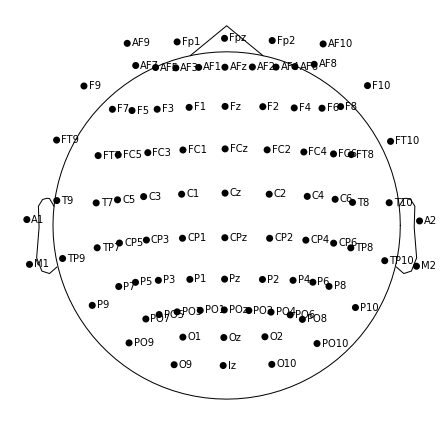

In [6]:
mne.viz.plot_montage(montage, scale_factor=20, show_names=True, kind='topomap', show=True, sphere=None, verbose=None);

In [14]:
# redefining the reference to a common average
raw_data.set_eeg_reference('average', projection=False, verbose=False)

<RawBrainVision | Group6_own.eeg, 32 x 759000 (759.0 s), ~185.4 MB, data loaded>

# DATA TIME - lets look at the raw data ..
### and maybe exclude a few channels

Using matplotlib as 2D backend.
Opening raw-browser...


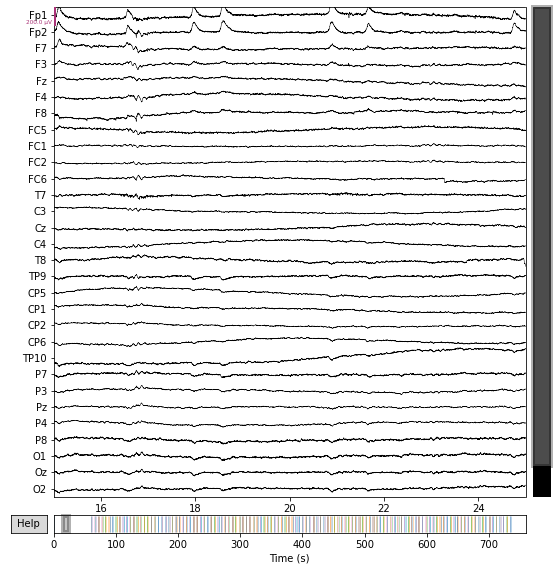

In [15]:
mne.viz.plot_raw(raw_data, n_channels = 30, scalings = dict(eeg = 0.0001), start = 15, duration = 10);

Opening raw-browser...


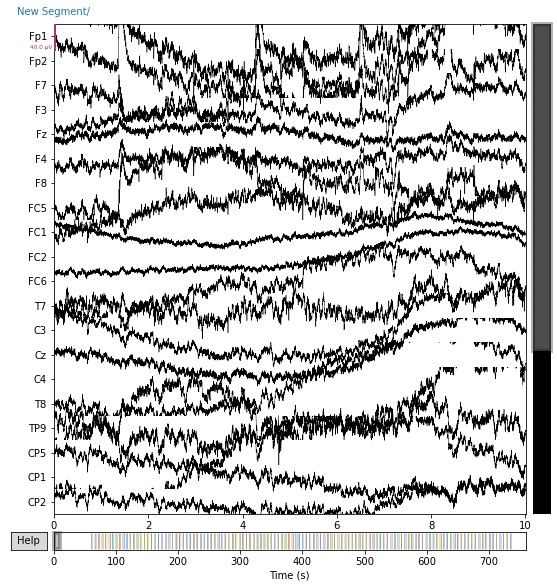

In [ ]:
# selecting only EEG and stimulus data & plotting raw data
raw_data.pick_types(meg=False, eeg=True, stim=True, exclude=[])
raw_data.plot();


Right now we are plotting using the default argument values of the plot() function. Try to play around with the function in order to:

- Plot all EEG channels simultaneously
- Plot a full minute of the recording
- Give the plot a fitting title

Hint: if you are in VS Code, you can see what the arguments of a function are by hovering over the function with your cursor.

## Excluding bad channels
When plotting all 30 channels, you should be able to see that one channel seems bad (i.e. it is pretty flat). We want to mark it is bad in our data.

Opening raw-browser...


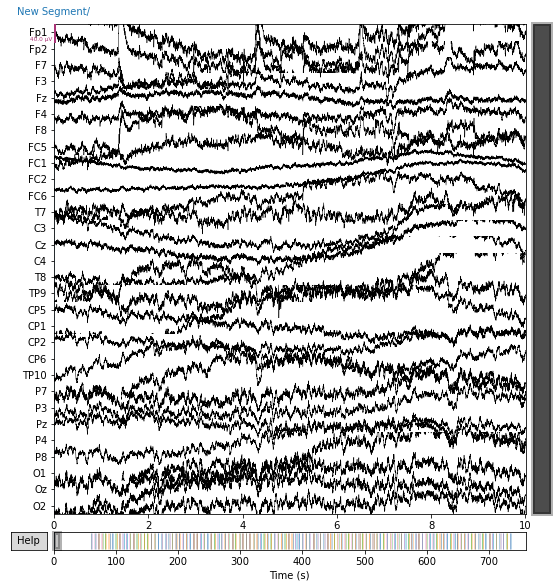

In [ ]:
## PLOTTING ALL SIMULTANEOUSLY 
raw_data.pick_types(meg=False, eeg=True, stim=True, exclude=[])
raw_data.plot(n_channels=30);

By visual inspection of the raw data, I argue that channel FC2 and FC1 look rather bad, since they are quite flat, and thus doesn't seem to contain much signal.
we additionally remove Fp1 and Fp2, because they seem to pick up some signal form the eyeblinks.
- we could also do ICA to try to salvage some of the data

*this time I dont remove the channels, but see how many are excluded when removing artefacts without ICA*

Opening raw-browser...


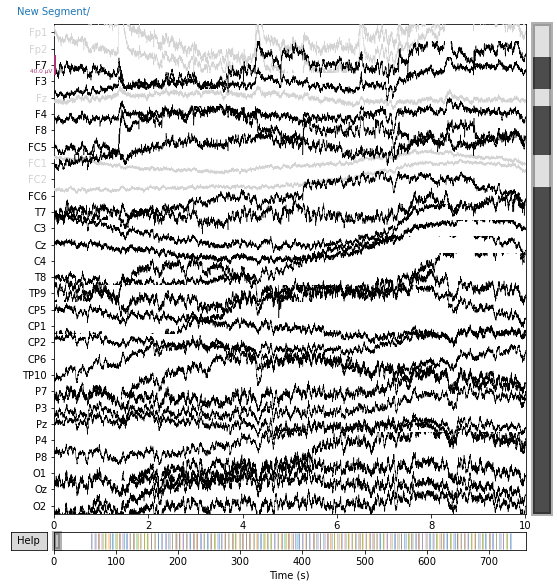

In [ ]:
# input the name of the bad EEG channel here, e.g. ['EEG 002']

#raw_data.info['bads'] = ['FC1', 'FC2', 'Fz', 'Fp1', 'Fp2']
#raw_data.plot(n_channels=30);

Now that we have marked the two channels as bad, we can exclude it. 

Opening raw-browser...


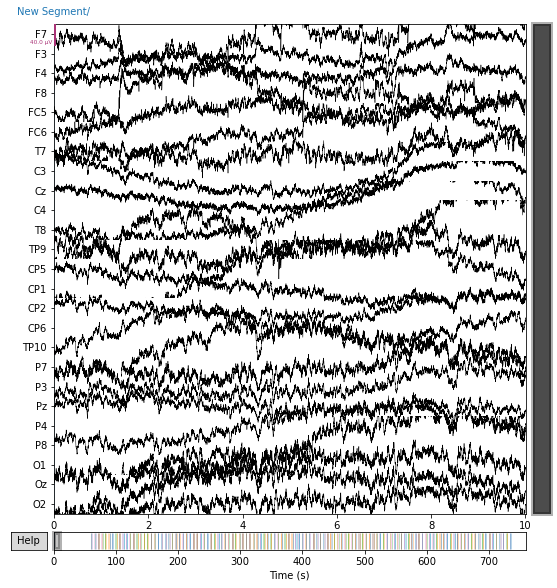

In [ ]:
# now we can exclude any channels in the 'bad channels' variable
#raw_data.pick_types(meg=False, eeg=True, stim=True, exclude='bads')
#raw_data.plot(n_channels=30);

Now it's gone! Let's move on to filtering the data in order to enhance the signal.

## Filtering
We high-pass filter the data at 0.1 Hz and low-pass filter the data at 40 Hz, following the typical practices of EEG preprocessing. The high-pass filter minimises slow drifts in the data (e.g. scalp potentials), while the low-pass filter excludes high-frequency noise (e.g. line noise (50 Hz) or EMG (muscle-related artefacts)), with frequencies higher than the frequencies of the signal we are interested in.

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)

Opening raw-browser...


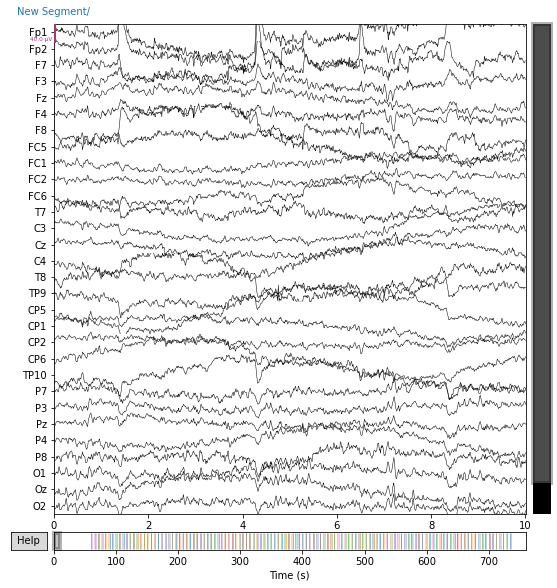

In [16]:
# high-pass filtering the data at 0.1 Hz and subsequently low-pass filtering at 40 Hz
data_fil = raw_data.filter(0.1, None)
data_fil = raw_data.filter(None, 40)

# plotting the filtered data for inspection
data_fil.plot(n_channels=30);

Compare the filtered signal to the raw signal you plotted in the beginning. Does it look cleaner?

I believe so yes ... but could also be do to the layout

## Artefact detection
There are many ways to detect and deal with artefacts. In this case I simply choose a value and reject anything above or below that value. We do this because we determine that values over or under this threshold are liekly not related to brain activity. For now, we just create the variable and then we use it to remove artefacts while epoching.

In [17]:
# rejecting everything over or under a threshold of 150 microvolts
# anything above or belove this threshold is likely not brain activity but artefacts 
reject = dict(eeg=150e-6)


okay now that I believe I have somewhat useful data, I start the epoching party. this is firstly done by getting an overview of the **event structures**

## Epoching
We now want to create epochs according to the events in our data, e.g. stimuli presentation. So first, we locate the events!

In [18]:
# this function locates any stimulus events in the recording (e.g. presentation of stimuli or button presses)
events = mne.events_from_annotations(data_fil)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 24', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 33', 'Stimulus/S 34', 'Stimulus/S 41', 'Stimulus/S 42', 'Stimulus/S 51', 'Stimulus/S 52', 'Stimulus/S111', 'Stimulus/S122', 'Stimulus/S131', 'Stimulus/S132']


now that we have the events, I will specify each of the unqie triggers that corresponds to the epoch.

#### The trigger list 
Triggerlist:
- 11: onset blue colour prime
- 12: onset red colour prime
- 13: onset left priming
- 14: onset right priming
- 15: onset no prime
- 21: onset task after blue priming
- 22: onset task after red priming
- 23: onset task after left priming
- 24: onset task after right priming
- 31: onset pause between blue prime and task
- 32: onset pause between red prime and task
- 33: onset pause between left prime and task
- 34: onset pause between right prime and task
- 41: onset task after no prime (left/a is correct)
- 42: onset task after no prime (right/l is correct)
- 51: onset pause between no prime and left/a task
- 52: onset pause between no prime and right/l task
- 111: correct blue prime or left prime task
- 122: correct red prime or right prime task
- 131: correct no prime task (left/a is correct)
- 132: correct no prime task (right/l is correct)
- 99999:

In [ ]:
np.unique(events[0][:,2])
list(events[1].values())

[99999,
 11,
 12,
 13,
 14,
 15,
 21,
 22,
 23,
 24,
 31,
 32,
 33,
 34,
 41,
 42,
 51,
 52,
 111,
 122,
 131,
 132]

In [21]:
# we can make a dictionary of what the event IDs represent
# by using '/' we can actually later index one dimension *across* the other, i.e. if we just write 'left' we get all events presented to the left side, both auditory and visual
event_id = {'Prime/cblue': 11, # onset blue colour prime
 'Wait/cblue': 31, # onset pause between blue prime and task
 'Task/cblue': 21, # onset task after blue priming
 'Prime/cred': 12, # onset red colour prime
 'Wait/cred': 32, # onset pause between blue prime and task
 'Task/cred': 22, # onset task after red priming
 'Prime/sleft': 13, # onset left priming
 'Wait/sleft': 33, # onset pause between left prime and task
 'Task/sleft': 23, # onset task after left priming
 'Prime/sright': 14, # onset right priming
 'Wait/sright': 34, # onset pause between blue prime and task
 'Task/sright': 24, # onset task after blue priming
 'Prime/no_prime': 15, # onset right priming
 'Wait/no_prime/left': 51, # onset pause between no prime and left task
 'Wait/no_prime/right': 51, # onset pause between no prime and right task
 'Task/no_prime/left': 41, # onset left_task after no_prime priming
 'Task/no_prime/right': 42, # onset right_task after no_prime priming
 'Correct/left_task': 111, # correct response ('a') to blue or left prime
 'Correct/right_task': 122, # correct response ('l') to red or right prime
 'Correct/no_prime/left_task': 131, # correct response ('a') to no_prime
 'Correct/no_prime/right_task': 132, # correct response ('l') to no_prime
 }

/var/folders/k4/ms5x119d5cd2s9ldsk71bkf00000gn/T/ipykernel_52861/948177431.py:2: RuntimeWarning: event 52 missing from event_id will be ignored
  mne.viz.plot_events(events[0], event_id=event_id);
/var/folders/k4/ms5x119d5cd2s9ldsk71bkf00000gn/T/ipykernel_52861/948177431.py:2: RuntimeWarning: event 99999 missing from event_id will be ignored
  mne.viz.plot_events(events[0], event_id=event_id);
/var/folders/k4/ms5x119d5cd2s9ldsk71bkf00000gn/T/ipykernel_52861/948177431.py:2: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(events[0], event_id=event_id);


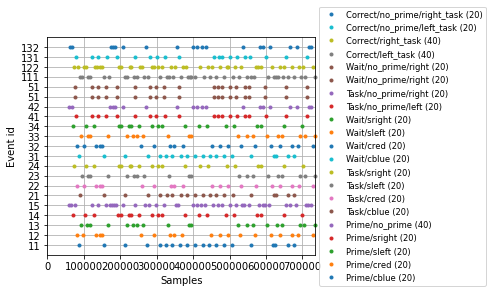

In [22]:
# plotting the events
mne.viz.plot_events(events[0], event_id=event_id);


The time window we establish span from 0.2 seconds before stimulus onset to 0.5 seconds after stimulus onset. The 200 milliseconds before the onset of the stimulus enables us to examine a baseline of activity without stimulus presentation. The 500 milliseconds after the stimulus onset denote the time in which we expect the effect to occur, since most EEG components arise before the 500 milliseconds mark.

In [23]:
# establishing time window
tmin, tmax = -0.2, 0.5

# choosing only EEG channels for epoching
picks = mne.pick_types(data_fil.info, meg=False, eeg=True, eog=False)

In [24]:
# creating the epochs using the variables created in the cell above, and timelocking to the events
# baseline time interval spans from beginning of the data (-0.2 s) to 0 s (stimulus onset)
# we use the reject variable we created earlier in order to remove artefacts
epochs = mne.Epochs(data_fil, events[0], event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=reject, preload=True)


Not setting metadata
460 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 460 events and 701 original time points ...
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'P7']
    Rejecting  epoch based on EEG : ['Fp1', 

As you can see, we are dropping some epochs that were deeemed 'bad' because they contain values over or under the threshold we defined, allowing us to exclude epochs with artefacts.

## Downsampling
Now we reduce the sample-rate to 250 Hz instead of 600. We do this after epoching, since downsampling before epoching can potentially mess with the precision of the extraction of epochs.

In [ ]:
# downsampling to 250 Hz
epochs_resampled = epochs.resample(250)

## Event Related Potentials - ERP
its time to look at the event related potentials ... which mean that we group each epoch by modality and look at the difference between them.

ERP's are event-related voltage changes in the ongoing EEG activity that are time-locked to sensory, motor, and cognitive events. ERPs can be used to identify and classify perceptual, memory and linguistic operations. 
In this case we first look at the number of event's which each matches a specific type of stimulus. 

In [ ]:
epochs_resampled

### ill just save these as a file to make analysis on
#repochs_resampled.save('EPOCHS-epo.fif')

 Now the '/' used in the event IDs comes in handy! To get all epochs with auditory stimuli, we can index the prime vs actual task from one another ' across the spatial/colour prime. 
 
 I then plot one channel to see the different signal here when you are either colour primed or spatial primed. In this case I go with the Oz since it is placed on the visual cortex. O stands for occipital lobe, in which the visual cortex is located. 

Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


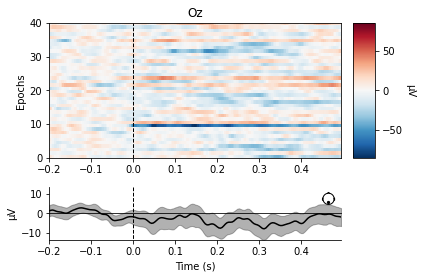

Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


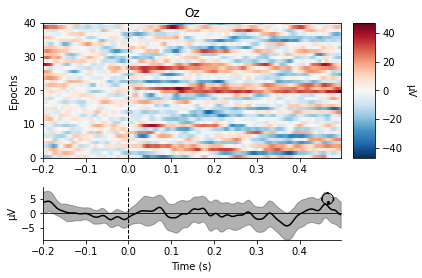

Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


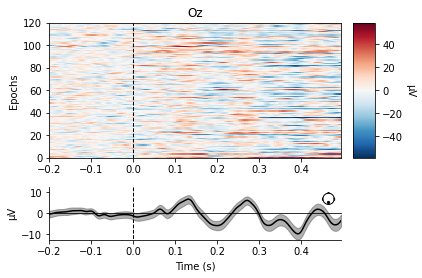

In [ ]:
## Sorting the color and spatial primes from one another.
prime_colour_epochs = epochs_resampled['Prime/cblue', 'Prime/cred']
prime_spatial_epochs = epochs_resampled['Prime/sleft', 'Prime/sright']
task_epochs = epochs_resampled['Task']

# plotting one channel as an example for each modality
prime_colour_epochs.plot_image(picks=['Oz']);
prime_spatial_epochs.plot_image(picks=['Oz']);
task_epochs.plot_image(picks=['Oz']);

### SOME KIND OF CONCLUSION HERE.
just by looking at the signal we see how the signals behave differently:

#### in PRIME COLOUR
the signal are mainly negative and with a fair confidence interval round it. Especially around epochs 10 something seems to be going on.

#### in PRIME SPATIAL
the signal are distributed around 0, but with a quite big confidence interval surrounding it. 

#### in TASK 
the confidence interval is very narrow, while the voltage of the signal differs a lot. 


The same thing can now be done to make a bit more generalized epochs, namely for all primes and tasks.
We here check how the signal behaves in one channel, the Oz.   

Not setting metadata
119 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


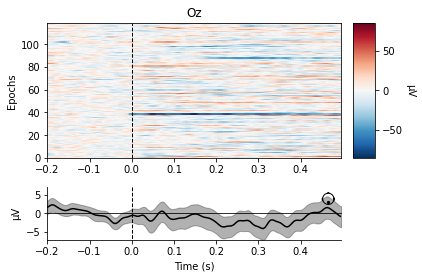

Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


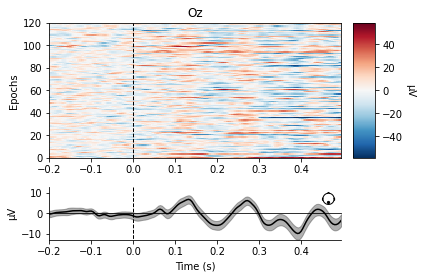

In [ ]:
# now lets do it again, but this time making it to match whether the participant were primed or in a task in the time window.
prime_epochs = epochs_resampled['Prime']
task_epochs = epochs_resampled['Task']

# plotting one channel as an example for each modality
prime_epochs.plot_image(picks=['Oz']);
task_epochs.plot_image(picks=['Oz']);

These plots show each epoch as one row of the image map for the chosen channel, with color representing signal magnitude. The average evoked response and the sensor location are shown below the image. This gives us an idea of whether there is consistency in the signal.

In your view, which is the most consistent signal of the two? Why do you think that is?

(hint 1: where is the EEG Oz channel located on the scalp?)

(hint 2: maybe try using plot_sensors and flagging show_names=True)

Which channel would you choose if you were to reverse the pattern of the signal consistencies? Go ahead and try it out...

### more genereal conclusion
now we can tell how the task signal in Oz differs quite much from the priming epochs. 


## EVOKED EPOCHS
what does evoked mean???













In [ ]:
## EVOKED EPOCHS - general for task and prime
## first we take the epochs based on the trigger, and then we take the avererage of those to get the evoked
prime_epochs = epochs_resampled['Prime']
task_epochs = epochs_resampled['Task']


#### MAKING THE GENERAL EVOKED
task_evoked = task_epochs.average() # [all task]
prime_evoked = prime_epochs.average() # [all prime]


### MAKING EPOCHS FOR ALL THE TRIGGERS COMBINING BY PRIME, TASK, WAIT AND CORRECT

In [ ]:
## PRIME EPOCHS Sorting the color and spatial primes from one another.
prime_colour_epochs = epochs_resampled['Prime/cblue', 'Prime/cred']
prime_spatial_epochs = epochs_resampled['Prime/sleft', 'Prime/sright']
prime_no_epochs = epochs_resampled['Prime/no_prime']

# TASK EPOCHS SPATIAL + colour PRIMING
task_spatial_epochs = epochs_resampled['Task/sleft', 'Task/sright']
task_colour_epochs = epochs_resampled['Task/cred', 'Task/cblue']
task_noprime_epochs = epochs_resampled['Task/no_prime/left', 'Task/no_prime/right']

# WAITING EPOCHS - the waiting time between task + prime
wait_col_prime_epochs = epochs_resampled['Wait/cblue', 'Wait/cred']
wait_spa_prime_epochs = epochs_resampled['Wait/sleft', 'Wait/sright']
wait_no_prime_epochs = epochs_resampled['Wait/no_prime/left', 'Wait/no_prime/right']
# THE RESPOND !!!! 
correct_noprime_epochs = epochs_resampled['Correct/no_prime/left_task', 'Correct/no_prime/right_task']
correct_epochs = epochs_resampled['Correct/left_task', 'Correct/right_task']


### trying to combine it all in a df
turned out this was rather unneccessary

In [ ]:
### making and looking at the dataframe for epochs df_prim_col
df_prim_col = prime_colour_epochs.to_data_frame()
#df_prim_col.iloc[:5, :10]
df_prim_spa = prime_spatial_epochs.to_data_frame()
df_np = prime_no_epochs.to_data_frame()

df_task_spa = task_spatial_epochs.to_data_frame()
df_task_col = task_colour_epochs.to_data_frame()
df_np_task = task_noprime_epochs.to_data_frame()


df_wait_col = wait_col_prime_epochs.to_data_frame()
df_wait_spa = wait_spa_prime_epochs.to_data_frame()
df_wait_np = wait_no_prime_epochs.to_data_frame()

df_cor_np = correct_noprime_epochs.to_data_frame()
df_cor = correct_epochs.to_data_frame()


## combining by making a list:
df1 = pandas.DataFrame(df_prim_spa)
df2 = pandas.DataFrame(df_prim_col)
df3 = pandas.DataFrame(df_np)
df4 = pandas.DataFrame(df_task_col)
df5 = pandas.DataFrame(df_task_spa)
df6 = pandas.DataFrame(df_np_task)
df7 = pandas.DataFrame(df_wait_col)
df8 = pandas.DataFrame(df_wait_spa)
df9 = pandas.DataFrame(df_wait_np)
df10 = pandas.DataFrame(df_cor_np)
df11 = pandas.DataFrame(df_cor)

merged_df = pandas.concat([df1, df2,df3, df4, df5, df6, df7, df8, df9, df10, df11 ])
merged_df

#merged_df.mne_save('NAME'-epo.fif)

#np.unique(merged_df['epoch'])

AttributeError: 'DataFrame' object has no attribute 'mne_save'

### MAKING AN EVOKED FOR EACH EPOCH:

In [ ]:
## EVOKED EPOCHS
#### now lets make all of the epochs into evoked epochs, that are ready to become data:

### PRIME
prime_col_evoked = prime_colour_epochs.average()
prime_spa_evoked = prime_spatial_epochs.average()
prime_no_evoked = prime_no_epochs.average()

### TASK 
task_col_evoked = task_colour_epochs.average()
task_spa_evoked = task_spatial_epochs.average() 
task_noprime_evoked = task_noprime_epochs.average()

### WAIT 
wait_col_evoked = wait_col_prime_epochs.average()
wait_spa_evoked = wait_spa_prime_epochs.average()
wait_noprime_evoked = wait_no_prime_epochs.average()

### CORRECT 
correct_evoked = correct_epochs.average()
correct_noprime_evoked = correct_noprime_epochs.average()




## PLOTTING THE EVOKED
Now that I have the evoked, I can plot and compare the signals 

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


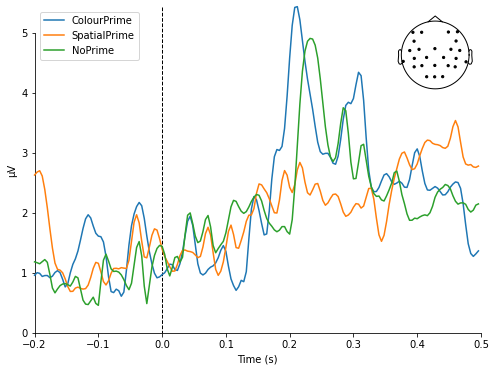

[<Figure size 576x432 with 2 Axes>]

In [ ]:
# plotting the two evokeds together
mne.viz.plot_compare_evokeds(dict(ColourPrime = prime_col_evoked , SpatialPrime =prime_spa_evoked, NoPrime = prime_no_evoked),
                             legend='upper left', show_sensors='upper right')

Looking a bit closer at the averaged responses, here visualized with the gfp (global field power).

GFP is actually the same as taking the standard deviation across all channels in each time sample. This tells us in which timepoints we see the biggest difference between different channels, which in turn is indicative of some kind of (more or less) focal activity. Quite neat actually.

Looking at the plot, where in time do you see the strongest response in the auditory and visual conditions, respectively?
Do those timepoints match any well-known components relevant in this context? 

(hint: N100 and N170)

Now compare with the "joint" plots below - do those plots match your observations from the GFP-plots?

No projector specified for this dataset. Please consider the method self.add_proj.


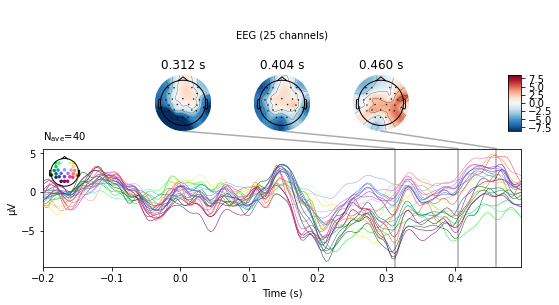

No projector specified for this dataset. Please consider the method self.add_proj.


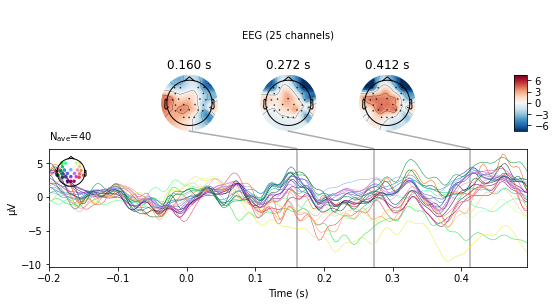

No projector specified for this dataset. Please consider the method self.add_proj.


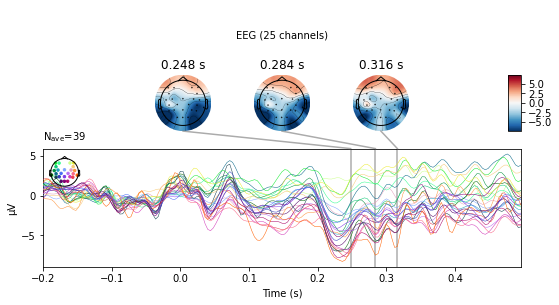

In [ ]:
prime_col_evoked.plot_joint(picks='eeg');
prime_spa_evoked.plot_joint(picks='eeg');
prime_no_evoked.plot_joint(picks='eeg');

As a final note, we can create contrasts (aka. difference waves) on the fly by using the combine_evoked-function (in combination with the weights=[1, -1]-parameter).

This also gives us a chance to try out one final plotting function, namely the plot_topo-function. This function plots the difference waves (or whichever traces we choose to plot) for each channel in their positions on the scalp.

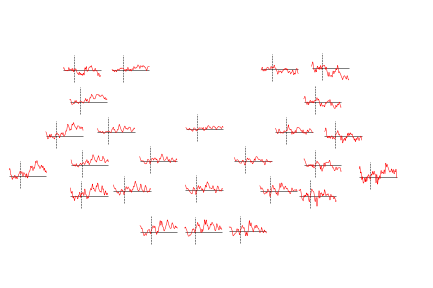

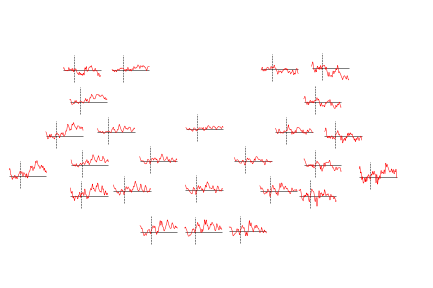

In [ ]:
evoked_diff = mne.combine_evoked([prime_spa_evoked, prime_col_evoked], weights=[1, -1])
evoked_diff.pick_types(eeg=True).plot_topo(color='r', legend=False)


## Independent component analysis (ICA)
ICA can be used for artefact detection, since it identifies seperate components of the signal that have been combined during recording. That means that we can actually separate noise compoenents, such as eye blinks, from the rest of the signal, and thereby exclude them.

In [ ]:
# set up and fit the ica with 800 iterations with a random seed at 97
# n_components=0.95 ensures that the number of components selected explain at least 95% of the variance in the data
ica = mne.preprocessing.ICA(n_components=0.95, random_state=97, max_iter=800)
ica.fit(data_fil)

Fitting ICA to data using 25 channels (please be patient, this may take a while)
Selecting by explained variance: 17 components


/Users/laura/opt/miniconda3/envs/methods3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA took 331.8s.


Method,fastica
Fit,800 iterations on raw data (759000 samples)
ICA components,17
Explained variance,95.1 %
Available PCA components,25
Channel types,eeg
ICA components marked for exclusion,—


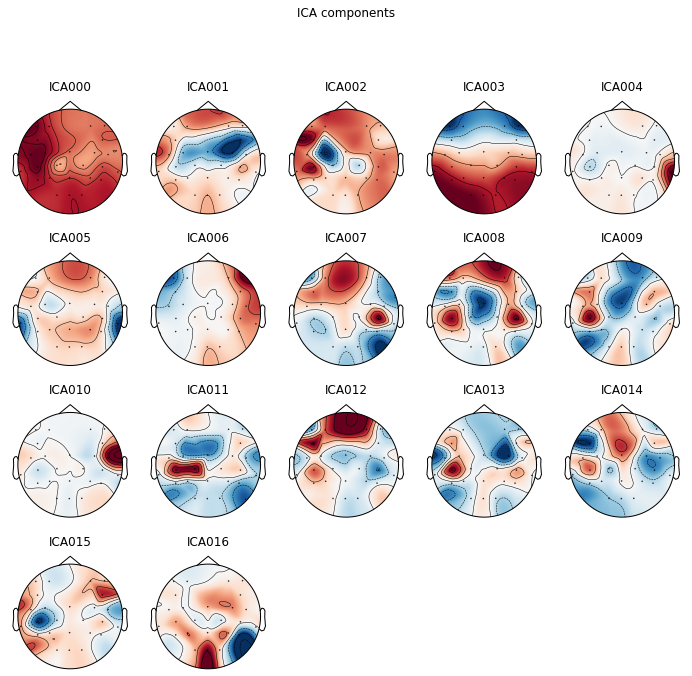

In [ ]:
# plotting the ica components
ica.plot_components();

Creating RawArray with float64 data, n_channels=17, n_times=759000
    Range : 0 ... 758999 =      0.000 ...   758.999 secs
Ready.
Opening ica-browser...


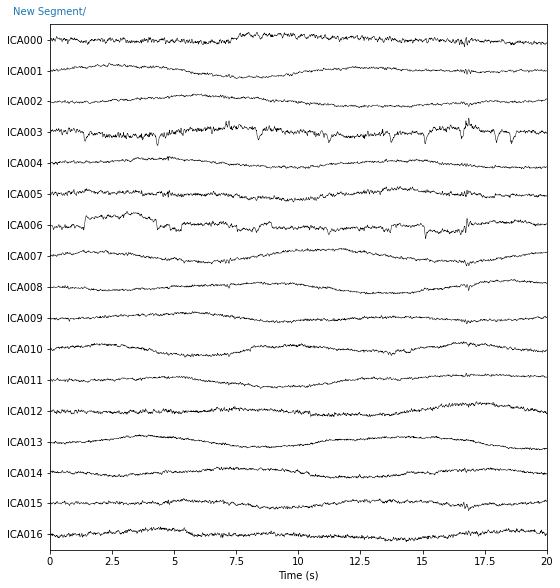

In [ ]:
# plotting the time series of the ica
ica.plot_sources(data_fil, show_scrollbars=False);

From visual inspection of the topographic maps and the time series plots of the components, we can see that the first component seems to capture noise. Consequently, we can remove it and thereby extract these artefacts from the data.

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
379 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


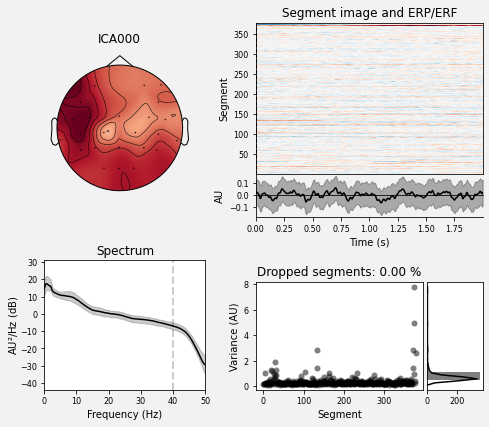

In [ ]:
# the first component is excluded based on visual inspection
ica.exclude = [0]
ica.plot_properties(data_fil, picks=ica.exclude);

We can now apply the ICA to the data.

In [ ]:
# applying the ica to the data
data_ica = ica.apply(data_fil)

Applying ICA to Raw instance
    Transforming to ICA space (17 components)
    Zeroing out 1 ICA component
    Projecting back using 25 PCA components


Opening raw-browser...


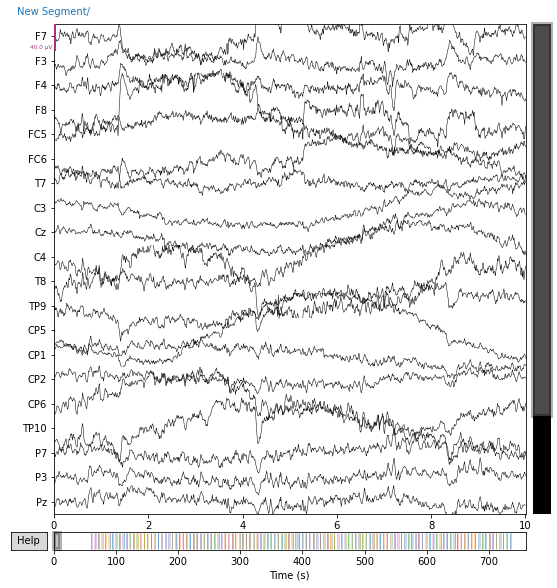

In [ ]:
# plotting the data after filtering and ica
data_ica.plot();

Now try to run 
- artefact-detection
- epoching
- downsampling
- the single-trial plots
- the evokeds plots

(i.e. exactly like you just did in the above)

Now compare your results with and without ICA - can you tell any differences between the two, just qualitatively speaking?